# Models


## Model 3

- get_dummies for categorical data + column "pdays".
- perform feature selection
- perform Kmeans

## Import libraries/packages 

In [83]:
### General libraries ###
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import graphviz 
from graphviz import Source
from IPython.display import SVG
import os

##################################

### ML Models ###
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree.export import export_text
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

##################################

### Metrics ###
from yellowbrick.classifier import ConfusionMatrix
from sklearn import metrics
from sklearn.metrics import f1_score,confusion_matrix, mean_squared_error, mean_absolute_error, classification_report, roc_auc_score, roc_curve, precision_score, recall_score

## Part 1: Load and clean the data

In this section we will load the data from the csv file and check for any "impurities", such as null values or duplicate rows. If any of these will appear, we will remove them from the data set. We will also plot the correlations of the class column with all the other columns.

In [84]:
# Load the data.
data = pd.read_csv('bank-additional/bank-additional-full.csv')

# Information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [85]:
# Value counts for categorical columns
for i in data.columns[data.dtypes == 'object']:
    print(data[i].value_counts(), '\n')

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64 

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64 

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64 

no         32588
unknown     8597
yes            3
Name: default, dtype: int64 

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64 

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64 

cellular     26144
telephone    15044
Name: contact, dtype: int64 

may    13769
jul     717

Now we check for duplicate rows. If any, we remove them from the data set, since they provide only reduntant information.

In [86]:
# Check for duplicate rows.
print(f"There are {data.duplicated().sum()} duplicate rows in the data set.")

# Remove duplicate rows.
data = data.drop_duplicates()
print("The duplicate rows were removed.")

There are 12 duplicate rows in the data set.
The duplicate rows were removed.


We also check for null values.

In [87]:
# Check for null values.
print(
    f"There are {data.isna().any().sum()} cells with null values in the data set.")

There are 0 cells with null values in the data set.


In [88]:
# Information about the data set after the cleaning.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
age               41176 non-null int64
job               41176 non-null object
marital           41176 non-null object
education         41176 non-null object
default           41176 non-null object
housing           41176 non-null object
loan              41176 non-null object
contact           41176 non-null object
month             41176 non-null object
day_of_week       41176 non-null object
duration          41176 non-null int64
campaign          41176 non-null int64
pdays             41176 non-null int64
previous          41176 non-null int64
poutcome          41176 non-null object
emp.var.rate      41176 non-null float64
cons.price.idx    41176 non-null float64
cons.conf.idx     41176 non-null float64
euribor3m         41176 non-null float64
nr.employed       41176 non-null float64
y                 41176 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [89]:
# OneHotEncoder for categorical data + 'pdays'
features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week',
            'pdays', 'poutcome']
data = pd.get_dummies(data, columns=features)

# Label encoding on column "y".
le = LabelEncoder()
data['y'] = le.fit_transform(data['y'])

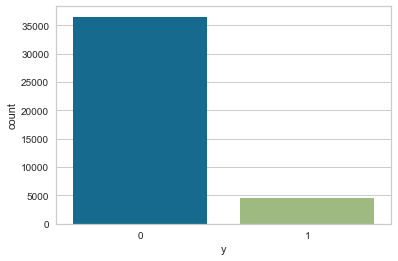

In [91]:
sns.countplot(x=data['y'], data=data)

Below is the plot of the correlation matrix for the data set.

## Part 2: Pre-processing

In this part we prepare our data for our models. This means that we choose the columns that will be our independed variables and which column the class that we want to predict. Once we are done with that, we split our data into train and test sets and perfom a standardization upon them.

In [92]:
# Distinguish attribute columns and class column.
X = data.drop(columns=['y'])
y = data['y']

## Feature selection

In [93]:
from sklearn.feature_selection import SelectKBest

In [94]:
def find_best_k(X, y, tol=0.001, n_iter_no_change=10, n_clusters=2, verbose=False):
    scores = []
    n_features = len(X.columns)
    no_improvement_counter = 0
    best_validation_score_ = -np.inf

 # Main loop
    for kappa in range(1, n_features+1):
        X_new = SelectKBest(k=kappa).fit_transform(X, y)
        sc = StandardScaler()
        sc.fit(X_new)
        X_new = sc.transform(X_new)
        X_new = pd.DataFrame(X_new)
        model = KMeans(n_clusters=2, random_state=25).fit(X_new)
        X_new['cluster'] = model.labels_
        X_train, X_test, y_train, y_test = train_test_split(
            X_new, y, test_size=0.3, random_state=25)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    # Initialize a Logistic Regression estimator.
        logreg = LogisticRegression(
            multi_class='auto', random_state=25, n_jobs=-1)
    # Train the estimator.
        logreg.fit(X_train, y_train)
        kappa_score = cross_val_score(logreg, X_new, y, cv=10).mean()
        scores.append(kappa_score)
        last_valid_score = scores[-1]

        if verbose:
            print(kappa, no_improvement_counter)
            print(scores)

        if last_valid_score < (best_validation_score_ + tol):
            no_improvement_counter += 1
        else:
            no_improvement_counter = 0

        if last_valid_score > best_validation_score_:
            best_validation_score_ = last_valid_score
            
        if no_improvement_counter > n_iter_no_change:
            break

    print(
        f'kappa: {scores.index(best_validation_score_)+1} with score: {best_validation_score_.round(3)}')

In [45]:
find_best_k(X, y, verbose=1)

1 0
[0.8924117746776152]
2 0
[0.8924117746776152, 0.8747529374820026]
3 1
[0.8924117746776152, 0.8747529374820026, 0.8851002836767154]
4 2
[0.8924117746776152, 0.8747529374820026, 0.8851002836767154, 0.8851974359031829]
5 3
[0.8924117746776152, 0.8747529374820026, 0.8851002836767154, 0.8851974359031829, 0.8682676621402887]
6 4
[0.8924117746776152, 0.8747529374820026, 0.8851002836767154, 0.8851974359031829, 0.8682676621402887, 0.8677090088207923]
7 5
[0.8924117746776152, 0.8747529374820026, 0.8851002836767154, 0.8851974359031829, 0.8682676621402887, 0.8677090088207923, 0.8673932331182744]
8 6
[0.8924117746776152, 0.8747529374820026, 0.8851002836767154, 0.8851974359031829, 0.8682676621402887, 0.8677090088207923, 0.8673932331182744, 0.8670532681570144]
9 7
[0.8924117746776152, 0.8747529374820026, 0.8851002836767154, 0.8851974359031829, 0.8682676621402887, 0.8677090088207923, 0.8673932331182744, 0.8670532681570144, 0.8667861128055849]
10 8
[0.8924117746776152, 0.8747529374820026, 0.8851002

In [65]:
# Best k for cv accuracy: 1

In [95]:
X = SelectKBest(k=1).fit_transform(X, y)

## Kmeans analysis

In [96]:
# Create a k-means model with k=2
model = KMeans(n_clusters=2,random_state=25)

In [97]:
# Standardization
sc = StandardScaler()
sc.fit(X)
X = sc.transform(X)
X = pd.DataFrame(X)

In [98]:
X['cluster'] = model.fit_predict(X)

In [99]:
# Split to train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=25)

In [100]:
# Standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Part 3: Modeling

In this section we build and try 3 models:
 - Logistic Regression
 - Decision tree
 - Neural network


## Logistic Regression

In [101]:
# Initialize a Logistic Regression estimator.
logreg = LogisticRegression(multi_class='auto', random_state=25, n_jobs=-1)

# Train the estimator.
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=25,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [102]:
# Make predictions.
log_pred = logreg.predict(X_test)

# CV score for MLP
cv_logreg = cross_val_score(logreg, X, y, cv=10).mean()

## Metrics for Logistic Regression

In [103]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % logreg.score(X_test, y_test))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.3f' % cv_logreg)

# Precision
print('Precision: %.3f' % precision_score(y_test, log_pred))

# Recall
print('Recall: %.3f' % recall_score(y_test, log_pred))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, log_pred))

Accuracy: 0.897
Cross-validation accuracy: 0.892
Precision: 0.597
Recall: 0.170
F1 score: 0.264


In [104]:
# Predict probabilities for the test data.
logreg_probs = logreg.predict_proba(X_test)

# Keep Probabilities of the positive class only.
logreg_probs = logreg_probs[:, 1]

# Compute the AUC Score.
auc_logreg = roc_auc_score(y_test, logreg_probs)
print('AUC: %.2f' % auc_logreg)

AUC: 0.82


## Confusion matrix for Logistic Regression

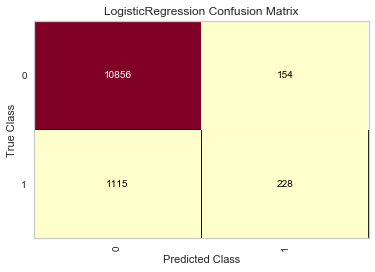

In [105]:
# Print confusion matrix for Logistic Regression.
cm = ConfusionMatrix(logreg, is_fitted=True)
cm.score(X_test, y_test)
cm.poof()

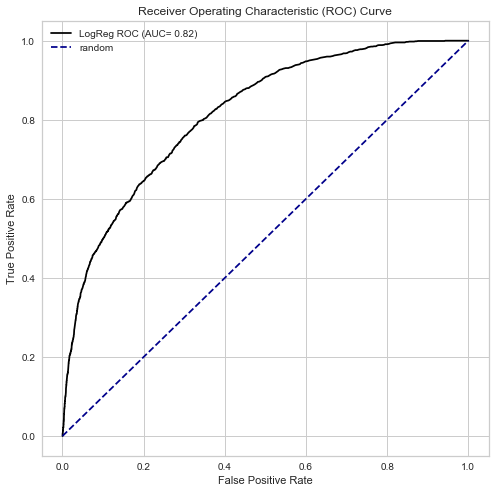

In [106]:
# Get the ROC curves.
logreg_fpr, logreg_tpr, logreg_thresholds = roc_curve(y_test, logreg_probs)

# Plot the ROC curves.
plt.figure(figsize=(8, 8))
plt.plot(logreg_fpr, logreg_tpr, color='black',
         label='LogReg ROC (AUC= %0.2f)' % auc_logreg)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Decision tree

In [107]:
# Initialize a decision tree estimator.
tr = tree.DecisionTreeClassifier(max_depth=30, random_state=25)

# Train the estimator.
tr.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=25, splitter='best')

In [108]:
# Print the tree in a simplified version.
r = export_text(tr, feature_names=X.columns.tolist())
print(r)

|--- 0 <= 1.02
|   |--- 0 <= -0.20
|   |   |--- 0 <= -0.50
|   |   |   |--- 0 <= -0.68
|   |   |   |   |--- 0 <= -0.75
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- 0 >  -0.75
|   |   |   |   |   |--- 0 <= -0.75
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- 0 >  -0.75
|   |   |   |   |   |   |--- 0 <= -0.70
|   |   |   |   |   |   |   |--- 0 <= -0.72
|   |   |   |   |   |   |   |   |--- 0 <= -0.75
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- 0 >  -0.75
|   |   |   |   |   |   |   |   |   |--- 0 <= -0.73
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- 0 >  -0.73
|   |   |   |   |   |   |   |   |   |   |--- 0 <= -0.73
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |   |--- 0 >  -0.73
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- 0 >  -0.72
|   |   |   |   |   |   |   |   |--- 0 <= -0.

In [109]:
# Make predictions.
tr_pred = tr.predict(X_test)

# CV score for Decision tree
cv_tr = cross_val_score(tr, X, y, cv=10).mean()

## Metrics for Decision tree

In [110]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % tr.score(X_test, y_test))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.3f' % cv_tr)

# Precision
print('Precision: %.3f' % precision_score(y_test, tr_pred))

# Recall
print('Precision: %.3f' % recall_score(y_test, tr_pred))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, tr_pred))

Accuracy: 0.893
Cross-validation accuracy: 0.888
Precision: 0.520
Precision: 0.162
F1 score: 0.247


In [111]:
# Predict propabilities for the test data.
tr_probs = tr.predict_proba(X_test)

# Keep Probabilities of the positive class only.
tr_probs = tr_probs[:, 1]

# Compute the AUC Score.
auc_tr = roc_auc_score(y_test, tr_probs)
print('AUC: %.2f' % auc_tr)

AUC: 0.74


## Confusion Matrix for Decision tree

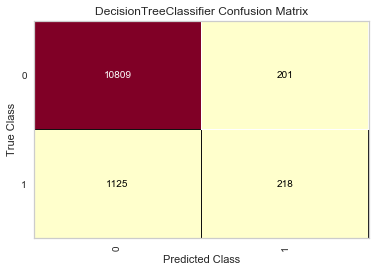

In [112]:
# Print confusion matrix for Decision tree.
cm = ConfusionMatrix(tr, is_fitted=True)
cm.score(X_test, y_test)
cm.poof()

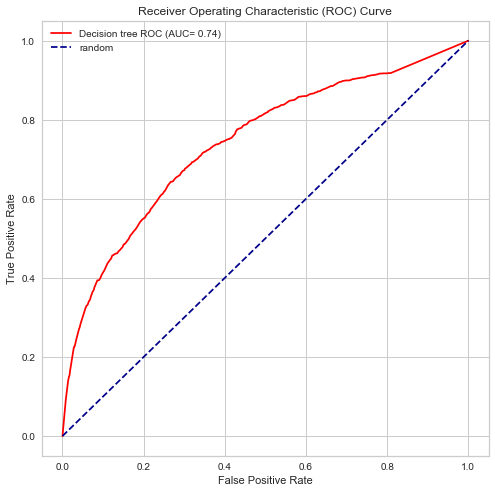

In [113]:
# Get the ROC Curves.
tr_fpr, tr_tpr, tr_thresholds = roc_curve(y_test, tr_probs)

# Plot the ROC curves.
plt.figure(figsize=(8, 8))
plt.plot(tr_fpr, tr_tpr, color='red',
         label='Decision tree ROC (AUC= %0.2f)' % auc_tr)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Neural network (MLP)

In [114]:
# Initialize a Multi-layer Perceptron classifier.
mlp = MLPClassifier(hidden_layer_sizes=(10), max_iter=1000,
                    random_state=25, shuffle=True)

# Train the classifier.
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=10, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=25, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [115]:
# Make predictions.
mlp_pred = mlp.predict(X_test)

# CV score for MLP
cv_mlp = cross_val_score(mlp, X, y, cv=10, n_jobs=-1).mean()

## Metrics for Neural network (MLP)

In [116]:
# Accuracy: 1 is perfect prediction.
print('Accuracy: %.3f' % mlp.score(X_test, y_test))

# Cross-Validation accuracy
print('Cross-validation accuracy: %0.3f' % cv_mlp)

# Precision
print('Precision: %.3f' % precision_score(y_test, mlp_pred))

# Recall
print('Recall: %.3f' % recall_score(y_test, mlp_pred))

# f1 score: best value at 1 (perfect precision and recall) and worst at 0.
print('F1 score: %.3f' % f1_score(y_test, mlp_pred))

Accuracy: 0.897
Cross-validation accuracy: 0.893
Precision: 0.596
Recall: 0.171
F1 score: 0.266


In [117]:
# Predict probabilities for the test data.
mlp_probs = mlp.predict_proba(X_test)

# Keep probabilities of the positive class only.
mlp_probs = mlp_probs[:, 1]

# Compute the AUC Score.
auc_mlp = roc_auc_score(y_test, mlp_probs)
print('AUC: %.2f' % auc_mlp)

AUC: 0.82


## Confusion Matrix for Neural network (MLP)

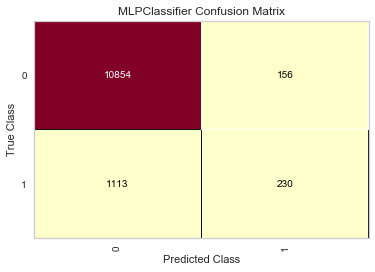

In [118]:
# Print confusion matrix for Decision tree.
cm = ConfusionMatrix(mlp, is_fitted=True)
cm.score(X_test, y_test)
cm.poof()

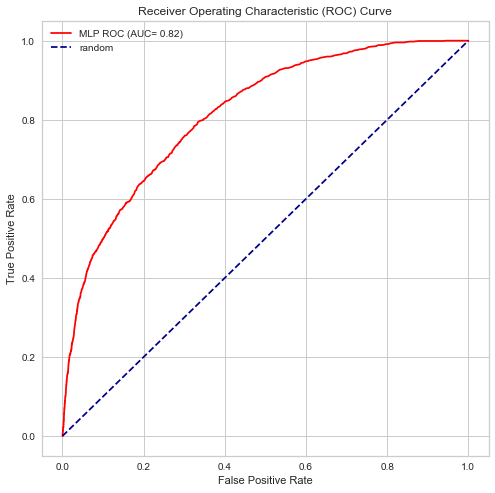

In [119]:
# Get the ROC curves.
mlp_fpr, mlp_tpr, mlp_thresholds = roc_curve(y_test, mlp_probs)

# Plot the ROC curve.
plt.figure(figsize=(8, 8))
plt.plot(mlp_fpr, mlp_tpr, color='red', label='MLP ROC (AUC= %0.2f)' % auc_mlp)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

## Results

In [120]:
metrics = ['Accuracy', 'CV accuracy', 'Precision', 'Recall', 'F1', 'AUC']

# Plot metrics.
fig = go.Figure(data=[
    go.Bar(name='Logistic Regression', x=metrics,
           y=[logreg.score(X_test, y_test), cv_logreg, precision_score(y_test, log_pred), recall_score(y_test, log_pred), f1_score(y_test, log_pred), auc_logreg]),
    go.Bar(name='Decision tree', x=metrics,
           y=[tr.score(X_test, y_test), cv_tr, precision_score(y_test, tr_pred), recall_score(y_test, tr_pred), f1_score(y_test, tr_pred), auc_tr]),
    go.Bar(name='Neural Network', x=metrics,
           y=[mlp.score(X_test, y_test), cv_mlp, precision_score(y_test, mlp_pred), recall_score(y_test, mlp_pred), f1_score(y_test, mlp_pred), auc_mlp]),
])

fig.update_layout(title_text='Metrics for all models',
                  barmode='group', xaxis_tickangle=-45, bargroupgap=0.05)
fig.show()

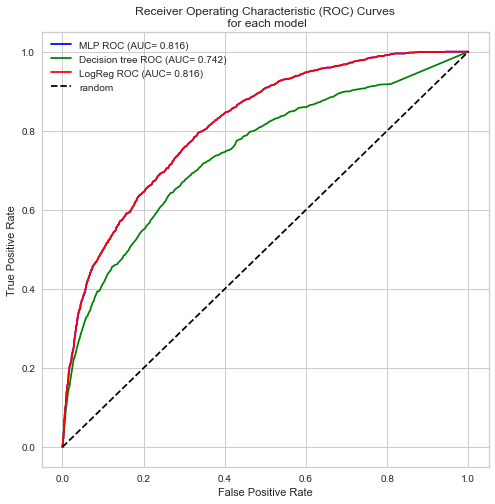

In [121]:
# Plot the ROC curve.
plt.figure(figsize=(8, 8))
plt.plot(mlp_fpr, mlp_tpr, color='blue',
         label='MLP ROC (AUC= %0.3f)' % auc_mlp)
plt.plot(tr_fpr, tr_tpr, color='green',
         label='Decision tree ROC (AUC= %0.3f)' % auc_tr)
plt.plot(logreg_fpr, logreg_tpr, color='red',
         label='LogReg ROC (AUC= %0.3f)' % auc_logreg)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves\n for each model')
plt.legend()
plt.show()

In [122]:
d = {
    'Models': ['Logistic Regression', 'Decision Tree', 'Neural Network (MLP)'],
    'Accuracy': [logreg.score(X_test, y_test), tr.score(X_test, y_test), mlp.score(X_test, y_test)],
    'CV Accuracy': [cv_logreg, cv_tr, cv_mlp],
    'Precision': [precision_score(y_test, log_pred), precision_score(y_test, tr_pred), precision_score(y_test, mlp_pred)],
    'Recall': [recall_score(y_test, log_pred), recall_score(y_test, tr_pred), recall_score(y_test, mlp_pred)],
    'F1': [f1_score(y_test, log_pred), f1_score(y_test, tr_pred), f1_score(y_test, mlp_pred)],
    'AUC': [auc_logreg, auc_tr, auc_mlp]
}

results = pd.DataFrame(data=d).round(3).set_index('Models')
results

,Accuracy,CV Accuracy,Precision,Recall,F1,AUC
Models,,,,,,
Logistic Regression,0.897,0.892,0.597,0.170,0.264,0.816
Decision Tree,0.893,0.888,0.520,0.162,0.247,0.742
Neural Network (MLP),0.897,0.893,0.596,0.171,0.266,0.816


## S. Moro, P. Cortez and P. Rita Results


|                     | AUC   |
|---------------------|-------|
| Logistic Regression | 0.900 |
| Decision tree       | 0.833 |
| Neural Network      | 0.929 |

## Evaluating Performance

### Hypothesis Testing
- $H_{0}$: There is no significant difference in the test set error rate of two supervised learner models $M_{1}$ and $M_{2}$ built with the same training data.
- $H_{1}$: There is significant difference in the test set error rate of two supervised learner models $M_{1}$ and $M_{2}$ built with the same training data.

### Comparing models with a single test set

**Step 1.** (Initialization). Given:
- Two models, $M_{1}$ and $M_{2}$ built with the same training data.
- One test set $A$ with $card(A)=n$.
- Error rate $E_{1}$ for model $M_{1}$ on test set $A$.
- Error rate $E_{2}$ for model $M_{2}$ on test set $A$.

**Step 2.** Compute:  

$$P=\frac{|E_{1}-E_{2}|}{\sqrt{\frac{(v_{1}+v_{2})}{n}}}$$

**Step 3.** Conclude:  
If $P≥2$, hypothesis $H_{1}$ holds. Otherwise, $H_{0}$ is true.


In [123]:
from itertools import combinations

# Dictionary with all the classifiers.
models = {'LogisticRegression': logreg,
          'DecisionTreeClassifier': tr,
          'MLPClassifier': mlp
          }

def evaluating_performance(models=None):
    if models == None:
        return 'No models to compare'
    else:
        for model in combinations(models.keys(), 2):
            confusion1 = confusion_matrix(
                y_test, models[model[0]].predict(X_test))
            TP1 = confusion1[1, 1]
            TN1 = confusion1[0, 0]
            FP1 = confusion1[0, 1]
            FN1 = confusion1[1, 0]
            E1 = (FP1+FN1)/len(X_test)
            confusion2 = confusion_matrix(
                y_test, models[model[1]].predict(X_test))
            TP2 = confusion2[1, 1]
            TN2 = confusion2[0, 0]
            FP2 = confusion2[0, 1]
            FN2 = confusion2[1, 0]
            E2 = (FP2+FN2)/len(X_test)
            var1 = E1*(1-E1)
            var2 = E2*(1-E2)
            n = len(X_test)
            P = abs(E1-E2)/np.sqrt((var1+var2)/n)
            print(
                f'Comparing Performance between {model[0]} and {model[1]}:', P.round(3))
            if P < 2:
                print(
                    f'There is no significant diferrence between {model[0]} and {model[1]}\n')
            else:
                print(
                    f'==>The models {model[0]} and {model[1]} are significant different<==\n')

In [124]:
evaluating_performance(models)

Comparing Performance between LogisticRegression and DecisionTreeClassifier: 1.183
There is no significant diferrence between LogisticRegression and DecisionTreeClassifier

Comparing Performance between LogisticRegression and MLPClassifier: 0.0
There is no significant diferrence between LogisticRegression and MLPClassifier

Comparing Performance between DecisionTreeClassifier and MLPClassifier: 1.183
There is no significant diferrence between DecisionTreeClassifier and MLPClassifier



***